In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy import optimize

In [5]:
class NeuralNetwork(object):
    def __init__(self, Lambda):
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 5
        
        self.w1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        self.w2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        self.Lambda = Lambda
    def forward(self, X):
        self.z2 = np.dot(X, self.w1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2,self.w2)
        yHat = self.sigmoid(self.z3)
        return yHat
    
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.w1**2)+np.sum(self.w2**2))
                                                                    
        return J
    
    def costFunctionPrime(self,X,y):
        
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.w2
        
        delta2 = np.dot(delta3, self.w2.T) * self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.w1
        
        return dJdW1, dJdW2
    
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.w1.ravel(), self.w2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.w1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.w2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))
    

In [3]:
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad 
    
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        self.testJ.append(self.N.costFunction(self.testX,self.testY))
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        return cost, grad
        
    def train(self, trainX, trainY, testX, testY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY
        self.testX = testX
        self.testY = testY
        #Make empty list to store costs:
        self.J = []
        self.testJ = []
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 113
         Function evaluations: 126
         Gradient evaluations: 126


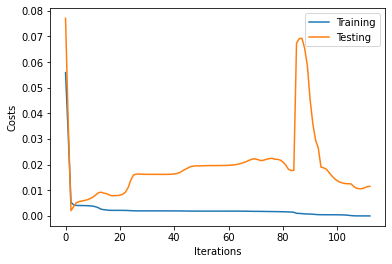

In [6]:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Testing Data:
testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize:
trainX = trainX/np.amax(trainX, axis=0)
trainY = trainY/100 #Max test score is 100

#Normalize by max of training data:
testX = testX/np.amax(trainX, axis=0)
testY = testY/100 #Max test score is 100

NN = NeuralNetwork(Lambda=0)
T = trainer(NN)
T.train(trainX, trainY, testX, testY)
plt.plot(T.J)
plt.plot(T.testJ)
plt.xlabel('Iterations')
plt.ylabel('Costs')
plt.legend(['Training', 'Testing'])